IA & Data science (LU3IN0226) -- 2020-2021
--------
*&copy; Equipe pédagogique: Vincent Guigue, Christophe Marsala, Edoardo Sarti, Olivier Schwander.*


## Projet 2021

### Préparation du notebook


<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

GIGACZ Kiara

## Données

Les données utilisées pour ce projet sont obtenues sur le site Kaggle, ce sont les données Google Play Store Apps accessibles à l'adresse https://www.kaggle.com/lava18/google-play-store-apps.

## Partie 1 - Description du problème

Le problème que nous souhaitons adresser dans ce notebook est celui de la catégorisation des applications à partir de leur nom. Pour cela, nous utilisons les colonnes "App" et "Category" du fichier "googleplaystore.csv".

Si la performance du classifieur résultant est satisfaisante, cela pourrait permettre à la Play Store de suggérer des catégories aux créateurs d'applications au moment où ils les soumettent.

## Partie 2 - Modèle

Pour résoudre ce problème, nous utilisons un classifieur Multi-class OAA qui utilise des Perceptrons. 

La description d'une application consiste d'un tableau de bits qui indiquent si certains mots sont présents ou non dans le nom de l'application. 

Pour obtenir ce tableau de bits, deux étapes sont nécessaires :

1. Nous faisons d'abord un traitement sur les noms des applications dans les données d'entraînement pour obtenir un dictionnaire contenant les mots les plus fréquents. La création de ce dictionnaire est soumise à plusieurs critères que nous pouvons choisir, comme la taille minimale d'un mot ou le nombre minimum d'occurrences du mot pour qu'il soit accepté. Ces critères sont nécessaires pour réduire la taille du dictionnaire.

2. Une fois le dictionnaire obtenu, nous parcourons les noms des applications des données d'entraînement avec la fonction convertText. Celle-ci crée un tableau indiquant la présence ou non de chaque mot du dictionnaire pour chaque application.

Le label d'une application est tout simplement la catégorie indiquée dans la base de données originale. Pour que ce label soit utilisable par le classifieur, nous le convertissons en un entier. Cet entier indique l'indice de la catégorie dans une liste qui contient toutes les catégories possibles.

Ce modèle permet aux perceptrons d'identifier les combinaisons de mots clés liés à chaque catégorie. Nous espérons donc que cela permettra au classifieur de pouvoir suggérer une catégorie pertinente pour chaque application.

## Partie 3 - Code

Importation des librairies et code à exécuter à l'ouverture du notebook.

In [2]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

import iads as iads
from iads import Classifiers as cl
from iads import utils as ut
from iads import wordProcessing as wp

# Pour recharger automatiquement le code modifié dans les modules
%load_ext autoreload
%autoreload 2

Chargement et aperçu des données : 

In [29]:
data = pd.read_csv("../GoogleApps/googleplaystore.csv")
data[0:5] 

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Pré-traitement des données : 

N.B. Nous considérons ici les applications qui ont le même nom des doublons, et nous ne gardons que la première occurrence. Ces lignes de données ne sont en réalité pas toujours exactement les mêmes. Parfois, elles ont une légère différence dans la colonne "Reviews". Dans notre cas, cela n'a aucun impact sur notre classification.

In [30]:
# Cleaning the data

# 1. Removing rows with missing data
data = data.dropna()

data = np.array(data) # converting dataframe to ndarray
print("Data shape after removing rows with missing information", data.shape)

# 2. Removing duplicates
app_names, indices, nb = np.unique(data[:,0], return_index=True, return_counts=True)
data = np.take(data, indices, axis=0)
print("Data shape after removing duplicates:", data.shape)

# 3. Removing unnecessary columns
data = data[:, 0:2]
print("Data shape after removing unnecessary columns:", data.shape)

# 4. Converting labels to numbers
uniqueCategories, data_labels = np.unique(data[:, 1:2], return_inverse=True)
data = np.hstack((data[:, 0:1], data_labels[:, None]))
print("Number of categories:", len(uniqueCategories))

Data shape after removing rows with missing information (9360, 13)
Data shape after removing duplicates: (8190, 13)
Data shape after removing unnecessary columns: (8190, 2)
Number of categories: 33


Code pour transformer la description des applications :

N.B. Le code des fonctions utilisées se trouve dans le package iads > wordProcessing.

In [85]:
def create_training_descriptions(data, minWordLength, minOccurrences, verbose=False):

    app_names = data[:,0]
    
    # Creating a dictionary containing the necessary words for our model
    dictionary = wp.createDictionary(app_names, minWordLength, minOccurrences, verbose=verbose)

    # App names are converted from strings to arrays of bits
    data_desc = wp.convertText(app_names, dictionary)

    return data_desc, dictionary

def create_testing_descriptions(data, dictionary):

    app_names = data[:,0]

    # App names are converted from strings to arrays of bits
    data_desc = wp.convertText(app_names, dictionary)

    return data_desc


# Note: 2-letter words like "TV", "FB", "vs", "ad", "AP" could be significant

Exemple de conversion des données (ici utilisant toute la base de données) :

In [86]:
data_desc, dictionary = create_training_descriptions(data, 3, 5, True)

Total number of unique words that fit requirements: 7562
Number of words that occur at least 5 times: 961
Length of final dictionary: 579


In [101]:
# Saving certain arrays to text files for easier perusal

# Save the dictionary to a txt file
keys = dictionary.keys()
keyList = [word for word in keys]
file = open("appNameDict.txt", "w", encoding="utf-8")
np.savetxt(file, keyList, "%s")
file.close()

# Save app_names to a txt file
file = open("appNames.txt", "w", encoding="utf-8")
np.savetxt(file, app_names, "%s")
file.close()

# Save categories to a txt file
file = open("uniqueCategories.txt", "w", encoding="utf-8")
np.savetxt(file, uniqueCategories, "%s")
file.close()

## Partie 4 - Protocole expérimental

Pour évaluer notre modèle, nous utilisons la validation croisée stratifiée.

In [97]:
import timeit

X = data[:, :-1]
Y = data[:, -1].astype(np.float32)

np.random.seed(42)   # on prend 42 comme graine
index = np.random.permutation(len(X)) # mélange des index
Xm = X[index]
Ym = Y[index]

niter = 10
perfTest = []
perfTrain = []

tic = timeit.default_timer() # heure de départ

for i in range(niter):
    Xapp, Yapp, Xtest, Ytest = ut.crossval_strat(Xm, Ym, niter, i)
    
    Xapp, dictionary = create_training_descriptions(Xapp, 3, 3, True)
    Xtest = create_testing_descriptions(Xtest, dictionary)
    _, dim = Xapp.shape
    
    multiOAA = cl.ClassifierMultiOAA(cl.ClassifierPerceptronBiais(dim, 1e-2))
    multiOAA.train(Xapp, Yapp)
    
    perfTrain.append(multiOAA.accuracy(Xapp, Yapp))
    perfTest.append(multiOAA.accuracy(Xtest, Ytest))
    
toc = timeit.default_timer() # heure d'arrivée

print(f'\nTemps mis: --> {toc-tic:.5f} secondes\n')
   
print("PerfTrain :", perfTrain, "\n")
print("PerfTest :", perfTest, "\n")

perfTest = np.array(perfTest)
print(f'Résultat global:\tmoyenne= {perfTest.mean():.3f}\técart-type= {perfTest.std():.3f}')

Total number of unique words that fit requirements: 7040
Number of words that occur at least 3 times: 1528
Length of final dictionary: 1071
Total number of unique words that fit requirements: 7056
Number of words that occur at least 3 times: 1519
Length of final dictionary: 1055
Total number of unique words that fit requirements: 7029
Number of words that occur at least 3 times: 1509
Length of final dictionary: 1066
Total number of unique words that fit requirements: 7040
Number of words that occur at least 3 times: 1514
Length of final dictionary: 1058
Total number of unique words that fit requirements: 7077
Number of words that occur at least 3 times: 1510
Length of final dictionary: 1046
Total number of unique words that fit requirements: 7069
Number of words that occur at least 3 times: 1515
Length of final dictionary: 1061
Total number of unique words that fit requirements: 7035
Number of words that occur at least 3 times: 1519
Length of final dictionary: 1050
Total number of uniq

Exemple de lancement sans validation croisée (entraîné et testé sur la base de données entière).

In [99]:
import timeit

X = data[:, :-1]
X, dictionary = create_training_descriptions(X, 3, 3, True)
Y = data[:, -1].astype(np.float32)

_, dim = X.shape

perfTrain = []

tic = timeit.default_timer() # heure de départ

multiOAA = cl.ClassifierMultiOAA(cl.ClassifierPerceptronBiais(dim, 1e-2))
multiOAA.train(X, Y)
perfTrain.append(multiOAA.accuracy(X, Y))

toc = timeit.default_timer() # heure d'arrivée

print(f'\nTemps mis: --> {toc-tic:.5f} secondes\n')
print("PerfTrain :", perfTrain, "\n")

Total number of unique words that fit requirements: 7562
Number of words that occur at least 3 times: 1645
Length of final dictionary: 1175

Temps mis: --> 9.09146 secondes

PerfTrain : [0.47374847374847373] 



Quelques comparaisons des prédictions vs la vraie catégorie :

In [100]:
for i in range(30, 60):
    print(app_names[i], "|| Predicted category:", uniqueCategories[multiOAA.predict(X[i])], "|| Real category:", uniqueCategories[int(Y[i])])

20WPM Amateur ham radio Koch CW Morse code trainer || Predicted category: COMMUNICATION || Real category: COMMUNICATION
21-Day Meditation Experience || Predicted category: HEALTH_AND_FITNESS || Real category: HEALTH_AND_FITNESS
211:CK || Predicted category: ART_AND_DESIGN || Real category: GAME
211:CK Lite || Predicted category: SOCIAL || Real category: GAME
24 megapixel hd camera || Predicted category: PHOTOGRAPHY || Real category: PHOTOGRAPHY
24/7 BZ Reis || Predicted category: ART_AND_DESIGN || Real category: TRAVEL_AND_LOCAL
2Date Dating App, Love and matching || Predicted category: DATING || Real category: DATING
2Do - Reminders, To-do List & Notes || Predicted category: PRODUCTIVITY || Real category: PRODUCTIVITY
2GIS: directory & navigator || Predicted category: TRAVEL_AND_LOCAL || Real category: TRAVEL_AND_LOCAL
2RedBeans || Predicted category: ART_AND_DESIGN || Real category: DATING
2ndLine - Second Phone Number || Predicted category: TOOLS || Real category: COMMUNICATION
30 D

Comparaison de la performance du classifieur en fonction de minOccurences : 

In [104]:
X = data[:, :-1]
Y = data[:, -1].astype(np.float32)

perf = []
for i in range(10):

    X = data[:, :-1]
    X, dictionary = create_training_descriptions(X, 3, i, True)
    Y = data[:, -1].astype(np.float32)
    
    _, dim = X.shape

    multiOAA = cl.ClassifierMultiOAA(cl.ClassifierPerceptronBiais(dim, 1e-2))
    multiOAA.train(X, Y)
    perf.append(multiOAA.accuracy(X, Y))

print("Perf :", perf, "\n")

Total number of unique words that fit requirements: 7562
Number of words that occur at least 0 times: 7559
Length of final dictionary: 6685
Total number of unique words that fit requirements: 7562
Number of words that occur at least 1 times: 7559
Length of final dictionary: 6685
Total number of unique words that fit requirements: 7562
Number of words that occur at least 2 times: 2556
Length of final dictionary: 1982
Total number of unique words that fit requirements: 7562
Number of words that occur at least 3 times: 1645
Length of final dictionary: 1175
Total number of unique words that fit requirements: 7562
Number of words that occur at least 4 times: 1215
Length of final dictionary: 789
Total number of unique words that fit requirements: 7562
Number of words that occur at least 5 times: 961
Length of final dictionary: 579
Total number of unique words that fit requirements: 7562
Number of words that occur at least 6 times: 807
Length of final dictionary: 440
Total number of unique wo

Même comparaison mais sur les données de test de la validation croisée : 

In [106]:
import timeit

perf = []
for j in range(1, 10):
    X = data[:, :-1]
    Y = data[:, -1].astype(np.float32)

    np.random.seed(42)   # on prend 42 comme graine
    index = np.random.permutation(len(X)) # mélange des index
    Xm = X[index]
    Ym = Y[index]

    niter = 10
    perfTest = []
    perfTrain = []

    tic = timeit.default_timer() # heure de départ

    for i in range(niter):
        Xapp, Yapp, Xtest, Ytest = ut.crossval_strat(Xm, Ym, niter, i)

        Xapp, dictionary = create_training_descriptions(Xapp, 3, j, True)
        Xtest = create_testing_descriptions(Xtest, dictionary)
        _, dim = Xapp.shape

        multiOAA = cl.ClassifierMultiOAA(cl.ClassifierPerceptronBiais(dim, 1e-2))
        multiOAA.train(Xapp, Yapp)

        perfTrain.append(multiOAA.accuracy(Xapp, Yapp))
        perfTest.append(multiOAA.accuracy(Xtest, Ytest))
        perf.append(multiOAA.accuracy(Xtest, Ytest))

    toc = timeit.default_timer() # heure d'arrivée

    print(f'\nTemps mis: --> {toc-tic:.5f} secondes\n')

    print("PerfTrain :", perfTrain, "\n")
    print("PerfTest :", perfTest, "\n")

    perfTest = np.array(perfTest)
    print(f'Résultat global:\tmoyenne= {perfTest.mean():.3f}\técart-type= {perfTest.std():.3f}')
    
print("Perf :", perf, "\n")

Total number of unique words that fit requirements: 7040
Number of words that occur at least 1 times: 7037
Length of final dictionary: 6194
Total number of unique words that fit requirements: 7056
Number of words that occur at least 1 times: 7053
Length of final dictionary: 6232
Total number of unique words that fit requirements: 7029
Number of words that occur at least 1 times: 7026
Length of final dictionary: 6222
Total number of unique words that fit requirements: 7040
Number of words that occur at least 1 times: 7037
Length of final dictionary: 6171
Total number of unique words that fit requirements: 7077
Number of words that occur at least 1 times: 7074
Length of final dictionary: 6236
Total number of unique words that fit requirements: 7069
Number of words that occur at least 1 times: 7066
Length of final dictionary: 6224
Total number of unique words that fit requirements: 7035
Number of words that occur at least 1 times: 7032
Length of final dictionary: 6193
Total number of uniq

Total number of unique words that fit requirements: 7077
Number of words that occur at least 5 times: 873
Length of final dictionary: 520
Total number of unique words that fit requirements: 7069
Number of words that occur at least 5 times: 885
Length of final dictionary: 505
Total number of unique words that fit requirements: 7035
Number of words that occur at least 5 times: 878
Length of final dictionary: 508
Total number of unique words that fit requirements: 7081
Number of words that occur at least 5 times: 889
Length of final dictionary: 513
Total number of unique words that fit requirements: 7046
Number of words that occur at least 5 times: 889
Length of final dictionary: 514
Total number of unique words that fit requirements: 7070
Number of words that occur at least 5 times: 901
Length of final dictionary: 508

Temps mis: --> 122.34764 secondes

PerfTrain : [0.39292970337261274, 0.3845320330488961, 0.3961804144656644, 0.4010564811052418, 0.39753487742110255, 0.3906271163483679, 0

Length of final dictionary: 167
Total number of unique words that fit requirements: 7070
Number of words that occur at least 9 times: 488
Length of final dictionary: 159

Temps mis: --> 109.73730 secondes

PerfTrain : [0.2517946634159556, 0.25626439116890154, 0.25084653934714884, 0.25816063930651495, 0.2614113503995666, 0.26032778003521606, 0.25978599485304077, 0.25992144114858456, 0.26479750778816197, 0.2503047541649736] 

PerfTest : [0.2379182156133829, 0.22676579925650558, 0.21437422552664187, 0.21685254027261464, 0.22304832713754646, 0.2379182156133829, 0.2503097893432466, 0.26889714993804215, 0.2577447335811648, 0.24287484510532836] 

Résultat global:	moyenne= 0.238	écart-type= 0.017
Perf : [0.4436183395291202, 0.4684014869888476, 0.42998760842627015, 0.4188351920693928, 0.459727385377943, 0.4423791821561338, 0.44981412639405205, 0.47831474597273854, 0.4634448574969021, 0.46592317224287483, 0.41759603469640644, 0.42874845105328374, 0.39776951672862454, 0.3915737298636927, 0.420074

## Partie 5 - Résultats

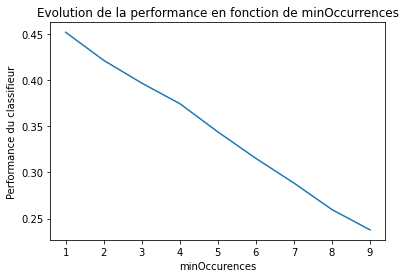

In [111]:
x = np.arange(1, 10)
y = []

for i in range(0, 90, 10):
    tmp = np.array(perf[i:i+10])
    y.append(tmp.mean())

plt.plot(x, y) 
plt.title("Evolution de la performance en fonction de minOccurrences")
plt.xlabel('minOccurences')
plt.ylabel('Performance du classifieur')

# Sauvegarde de la figure obtenue:
plt.savefig('supervised.png')

## Partie 6 - Analyse

En évaluant la performance de notre classifieur multi-class OAA (utilisant des Perceptrons) avec la validation croisée, nous pouvons obtenir une performance d'environ 0.45 sur les données de test si nous utilisons tous les mots. 

Etant donné que les applications sont classifiées en 33 catégories, cela indique une bonne performance (contre 0.03 si le classement était aléatoire).

Il semble naturel que la performance du classifieur se dégrade quand les contraintes appliquées aux mots qui sont contenus dans le dictionnaire sont serrées.

En regardant les résultats, nous pouvons observer que quand le classifieur se "trompe", cela peut souvent être dû à des raisons inévitables. Nous relevons quelques exemples si dessous : 

* Il est parfois difficile pour le créateur/la créatrice de choisir de manière objective la meilleure catégorie pour son application parmi les catégories proposées. 
    * Par exemple, le classifieur met l'application "350 Diy Room Decor Ideas" dans la catégorie "HOUSE_AND_HOME", alors que la catégorie donné par son créateur est ART_AND_DESIGN. L'application en question contient des photos de décorations possibles pour une maison. 

* Le nom d'une application peut parfois tout simplement suggérer une catégorie très fortement, même au jugement d'un être humain, mais faire référence à un autre type d'application. 
    * Par exemple, le classifieur met l'application "360-M Flight" dans la catégorie "TRAVEL_AND_LOCAL", alors que la catégorie donné par son créateur est "TOOLS". Il se trouve que cette application est une application pour controller un drone, mais même un être humain ne serait pas forcément capable de prédire cela en ayant juste le nom de l'application pour contexte.

* Nous pouvons voir avec 3 applications la raison pour le choix incorrecte du classifieur :
    * 3D Color Pixel by Number - Sandbox Art Coloring || Predicted category: FAMILY || Real category: ART_AND_DESIGN
    * 3D Color by Number with Voxels || Predicted category: FAMILY || Real category: FAMILY
    * 3D Color by Number: Voxel, Unicorn, Pixel Art 3D || Predicted category: FAMILY || Real category: FAMILY
    
* Certains applications sont nommées avec des noms uniques qui ne suggère pas leur catégorie : 
    * 2RedBeans || Predicted category: ART_AND_DESIGN || Real category: DATING
    * .R


Pour conclure, la performance de ce classifieur n'est pas parfaite, mais satisfaisante pour le problème que nous avons posé. L'utilisation de ce classifieur pour donner des suggestions aux créateurs d'applications pourraient leur faire gagner du temps dans presque 50% des cas. Néanmoins, si nous souhaitons recueillir plus de données pour le classifieur dans le futur, il faudra faire attention à ne pas utiliser des classements qui ont été proposés par le classifieur. Ex : en prenant les applications pour lesquelles le créateur a choisi de mettre un label autre que celui proposé, ou en ne proposant aucune suggestion à un petit sous-groupe de créateurs.